In [1]:
import pandas as pd
import numpy as np
from datasets import df_info

def parse_coupon_dates(s:str,format="%d/%m",sep=",")->str:
    vals = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    trans_dict = {k:v for k,v in enumerate(vals,start=1)}
    months = []
    if s and type(s)==str: #wenn leer, dann ist np.nan, aber bool(np.nan) = True
        for cp_dt in s.split(sep):
            ts = pd.to_datetime(cp_dt,format=format)
            months.append("AS-"+trans_dict[ts.month])
    return months

vals = df_info.loc[:,"COUPON DATES"].values
for val in vals:
     print(val," -> ", parse_coupon_dates(val))

01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
nan  ->  []
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/05,01/11  ->  ['AS-MAY', 'AS-NOV']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/05,01/11  ->  ['AS-MAY', 'AS-NOV']
01/05,01/11  ->  ['AS-MAY', 'AS-NOV']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,01/12  ->  ['AS-JUN', 'AS-DEC']
01/06,

In [3]:
df_info.loc[df_info["TYPE"]=="ILB",["NAME","ISSUE DATE"]]

,NAME,ISSUE DATE
Type,,
597973,CANADA 1991 4 1/4% 01/12/21 INDXLK.,1991-12-10 00:00:00
5771H1,CANADA 1993 PKG. STRIP 01/12/21 INDXLK.,1993-06-01 00:00:00
491970,CANADA 1993 CPN. STRIP 01/12/21 INDXLK.,1993-09-02 00:00:00
49197U,CANADA 1993 CPN. STRIP 01/12/19 INDXLK.,1993-09-02 00:00:00
49197V,CANADA 1993 CPN. STRIP 01/06/20 INDXLK.,1993-09-02 00:00:00
846111,CANADA 1995 4 1/4% 01/12/26 INDXLK.,1995-12-07 00:00:00
610286,CANADA 1999 4% 01/12/31 INDXLK.,1999-03-08 00:00:00
248402,CANADA 2003 3% 01/12/36 INDXLK.,2003-06-09 00:00:00
491986,CANADA 2004 CPN. STRIP 01/12/21 INDXLK.,2004-02-24 00:00:00


In [1]:
from cpi import RefCPI

cpi = RefCPI()
cpi.series

REF_DATE
1991-01-01     82.0
1991-02-01     82.0
1991-03-01     82.3
1991-04-01     82.3
1991-05-01     82.7
              ...  
2023-05-01    157.0
2023-06-01    157.2
2023-07-01    158.1
2023-08-01    158.7
2023-09-01    158.5
Name: VALUE, Length: 393, dtype: float64

<Axes: xlabel='REF_DATE'>

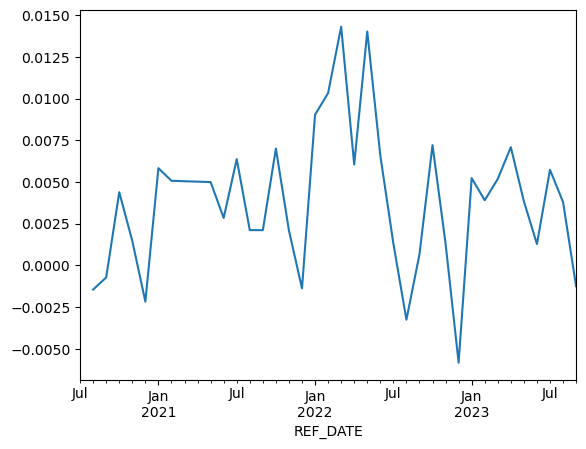

In [7]:
cpi.series.loc["2020-07-01":"2023-09-01"].pct_change().plot()

<Axes: xlabel='date'>

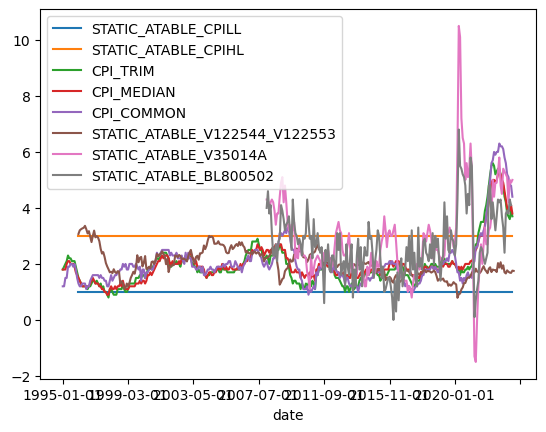

In [13]:
import pandas as pd
df_cpi_pct = pd.read_csv("data/inflation_indicators.csv",index_col="date")
df_cpi_pct.plot()

In [35]:
import pandas as pd
from tqdm import tqdm
from bond  import Bond,ILB
import pickle

with pd.ExcelFile("data/can.xlsx") as xls:
    df_prices = pd.read_excel(xls,"Price",index_col=0,parse_dates=True)
    df_prices.columns = df_prices.columns.map(str)

with pd.ExcelFile("data/can.xlsx") as xls:
    df_info = pd.read_excel(xls,"Info",index_col=0,dtype={"COUPON DATE":str,"ISSUE DATE":str,"REDEMPTION DATE":str,'START YEAR':str,'MATURITY YEAR':str})
    df_info.index = df_info.index.map(str)
    df_info.loc[:,"ISSUE DATE"] = df_info.loc[:,"ISSUE DATE"].map(pd.Timestamp)
    df_info.loc[:,"REDEMPTION DATE"] = df_info.loc[:,"REDEMPTION DATE"].map(pd.Timestamp)

all_bonds = df_info.index
ilbs = df_info[df_info["TYPE"]=="ILB"].index #nur vom typ ilb
noms = df_info[df_info["TYPE"]=="NOM"].index

bond_objs = []
for bond in all_bonds:
    name = df_info.loc[bond,"NAME"]
    issue_date = df_info.loc[bond,"ISSUE DATE"]
    redem_date = df_info.loc[bond,"REDEMPTION DATE"]
    prices = df_prices[bond]
    coupon_dates = Bond.parse_coupon_dates(df_info.loc[bond,"COUPON DATES"])

    if df_info.loc[bond,"TYPE"] == "ILB":
        coupon = df_info.loc[bond,"INDEX LINKED COUP"]
        ilb = ILB(issue_date,redem_date,coupon,coupon_freq=coupon_dates,id=bond,prices=prices,name=name)
        if ilb.redem_date < ilb.max_poss_redem_date: #nur dann kann der historische cashflow und damit ytm berechnet werden
            bond_objs.append(ilb)
    else:
        coupon = df_info.loc[bond,"COUPON"]
        bond_objs.append(Bond(issue_date,redem_date,coupon,coupon_freq=coupon_dates,id=bond,prices=prices,name=name))
"""
df = pd.DataFrame() #holds only date|YTMs for every bond -> csv
data = {} #holds yield curve dataframe date|price|TTM|YTM für jeden bond
for bond in tqdm(bond_objs):
     print("EVALUATING:", bond.id)
     yc = bond.yield_curve()
     data[bond.id] = bond.yield_curve()
     df[bond.id] = yc["YTM"]
"""

  0%|                                                                                                                                  | 0/27 [00:00<?, ?it/s]

EVALUATING: 597973
597973 :  2021-11-29 :  Failed to converge after 50 iterations, value is 6.942429510285882e+42.
597973 :  2021-11-30 :  Failed to converge after 50 iterations, value is 2.794406556474315e+71.
597973 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


  4%|████▌                                                                                                                     | 1/27 [01:26<37:30, 86.54s/it]

597973 :  2021-11-29 :  Failed to converge after 50 iterations, value is 6.942429510285882e+42.
597973 :  2021-11-30 :  Failed to converge after 50 iterations, value is 2.794406556474315e+71.
597973 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 49197V
49197V :  2020-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


  7%|█████████                                                                                                                 | 2/27 [01:43<19:07, 45.89s/it]

49197V :  2020-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491985
491985 :  2021-05-31 :  Failed to converge after 50 iterations, value is 7.643863247076988e+47.
491985 :  2021-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 11%|█████████████▌                                                                                                            | 3/27 [02:11<14:57, 37.38s/it]

491985 :  2021-05-31 :  Failed to converge after 50 iterations, value is 7.643863247076988e+47.
491985 :  2021-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491987
491987 :  2022-05-31 :  Failed to converge after 50 iterations, value is 3.861060618166953e+54.
491987 :  2022-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 15%|██████████████████                                                                                                        | 4/27 [02:39<12:57, 33.79s/it]

491987 :  2022-05-31 :  Failed to converge after 50 iterations, value is 3.861060618166953e+54.
491987 :  2022-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491989
491989 :  2023-05-31 :  Failed to converge after 50 iterations, value is 3.0352575243824747e+62.
491989 :  2023-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 19%|██████████████████████▌                                                                                                   | 5/27 [03:10<11:57, 32.63s/it]

491989 :  2023-05-31 :  Failed to converge after 50 iterations, value is 3.0352575243824747e+62.
491989 :  2023-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 49197U


 22%|███████████████████████████                                                                                               | 6/27 [03:33<10:21, 29.61s/it]

EVALUATING: 491986
491986 :  2021-11-30 :  Failed to converge after 50 iterations, value is 4.3162985907174586e+51.
491986 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 26%|███████████████████████████████▋                                                                                          | 7/27 [03:59<09:29, 28.45s/it]

491986 :  2021-11-30 :  Failed to converge after 50 iterations, value is 4.3162985907174586e+51.
491986 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491970
491970 :  2021-11-30 :  Failed to converge after 50 iterations, value is 3.5071013922812576e+70.
491970 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 30%|████████████████████████████████████▏                                                                                     | 8/27 [04:27<08:58, 28.34s/it]

491970 :  2021-11-30 :  Failed to converge after 50 iterations, value is 3.5071013922812576e+70.
491970 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 491988
491988 :  2022-11-30 :  Failed to converge after 50 iterations, value is 5.8497321337335036e+60.
491988 :  2022-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 33%|████████████████████████████████████████▋                                                                                 | 9/27 [05:02<09:02, 30.14s/it]

491988 :  2022-11-30 :  Failed to converge after 50 iterations, value is 5.8497321337335036e+60.
491988 :  2022-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 5771H1
5771H1 :  2021-11-29 :  Failed to converge after 50 iterations, value is 5.298662378626234e+47.
5771H1 :  2021-11-30 :  Failed to converge after 50 iterations, value is 1.753347148893134e+74.
5771H1 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 37%|████████████████████████████████████████████▊                                                                            | 10/27 [05:22<07:43, 27.26s/it]

5771H1 :  2021-11-29 :  Failed to converge after 50 iterations, value is 5.298662378626234e+47.
5771H1 :  2021-11-30 :  Failed to converge after 50 iterations, value is 1.753347148893134e+74.
5771H1 :  2021-12-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 846564


 41%|█████████████████████████████████████████████████▎                                                                       | 11/27 [08:49<21:55, 82.21s/it]

EVALUATING: 610451


 44%|█████████████████████████████████████████████████████▎                                                                  | 12/27 [13:30<35:38, 142.59s/it]

EVALUATING: 46269V


 48%|█████████████████████████████████████████████████████████▊                                                              | 13/27 [16:39<36:31, 156.54s/it]

EVALUATING: 2180M7


 52%|██████████████████████████████████████████████████████████████▏                                                         | 14/27 [19:05<33:15, 153.51s/it]

EVALUATING: 6487P3


 56%|██████████████████████████████████████████████████████████████████▋                                                     | 15/27 [21:18<29:26, 147.22s/it]

EVALUATING: 794D5D


 59%|███████████████████████████████████████████████████████████████████████                                                 | 16/27 [23:06<24:51, 135.63s/it]

EVALUATING: 860K02


 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 17/27 [24:10<18:59, 113.99s/it]

EVALUATING: 650WAD


 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 18/27 [24:37<13:09, 87.70s/it]

EVALUATING: 658V0W


 70%|█████████████████████████████████████████████████████████████████████████████████████▏                                   | 19/27 [24:50<08:44, 65.54s/it]

EVALUATING: 651FLY
651FLY :  2023-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 74%|█████████████████████████████████████████████████████████████████████████████████████████▋                               | 20/27 [24:58<05:36, 48.10s/it]

651FLY :  2023-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 3925TN


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                           | 21/27 [26:26<06:00, 60.01s/it]

EVALUATING: 5694XD


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 22/27 [27:44<05:27, 65.56s/it]

EVALUATING: 6561K8


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████                  | 23/27 [29:00<04:34, 68.59s/it]

EVALUATING: 8118P5


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 24/27 [30:37<03:50, 76.99s/it]

EVALUATING: 853J3Z
853J3Z :  2019-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 25/27 [30:52<01:56, 58.41s/it]

853J3Z :  2019-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 2360RY


/home/marcus/fm/bond.py:125: RuntimeWarning: invalid value encountered in scalar power
  s += cf/(1+r)**(dd/days_in_year)


2360RY :  2021-01-07 :  Failed to converge after 50 iterations, value is nan.


/home/marcus/fm/bond.py:125: RuntimeWarning: invalid value encountered in scalar power
  s += cf/(1+r)**(dd/days_in_year)


2360RY :  2021-01-08 :  Failed to converge after 50 iterations, value is nan.
2360RY :  2021-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


/home/marcus/fm/bond.py:125: RuntimeWarning: invalid value encountered in scalar power
  s += cf/(1+r)**(dd/days_in_year)
/home/marcus/fm/bond.py:125: RuntimeWarning: invalid value encountered in scalar power
  s += cf/(1+r)**(dd/days_in_year)
 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 26/27 [31:12<00:46, 46.92s/it]

2360RY :  2021-01-07 :  Failed to converge after 50 iterations, value is nan.
2360RY :  2021-01-08 :  Failed to converge after 50 iterations, value is nan.
2360RY :  2021-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.
EVALUATING: 615GG0
615GG0 :  2022-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [31:19<00:00, 69.61s/it]

615GG0 :  2022-01-11 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


In [36]:
with open("export/ytm_dataframes.pickle","wb") as f:
    pickle.dump(data,f)

df.to_csv("export/ytms.csv")

In [81]:
import ipywidgets as widgets
dd = widgets.Dropdown(options=df.columns,description="Bond")
log_chk = widgets.Checkbox(description="log")

def plot_ytm(bond:str,log:bool):
    fig, ax = plt.subplots()
    df_b = df[[bond]].dropna()
    df_b["redem_date"] = df_b.index.max()
    df_b["TTM"] = df_b["redem_date"] - df_b.index
    df_b["TTM"] = df_b["TTM"].map(lambda d: d.days)/365
    sns.lineplot(data=df_b,x="TTM",y=bond)
    if log:
        plt.yscale("log")
    plt.show()
    display(df_info.loc[bond,:])
out = widgets.interactive_output(plot_ytm, {"bond":dd,"log":log_chk})
display(dd,log_chk,out)

Dropdown(description='Bond', options=('597973', '49197V', '491985', '491987', '491989', '49197U', '491986', '4…

Checkbox(value=False, description='log')

Output()

In [26]:
yc1 = bond_objs[1].yield_curve()

49197V :  2020-06-01 :  Tolerance of 0.0001 reached. Failed to converge after 1 iterations, value is 0.0001.


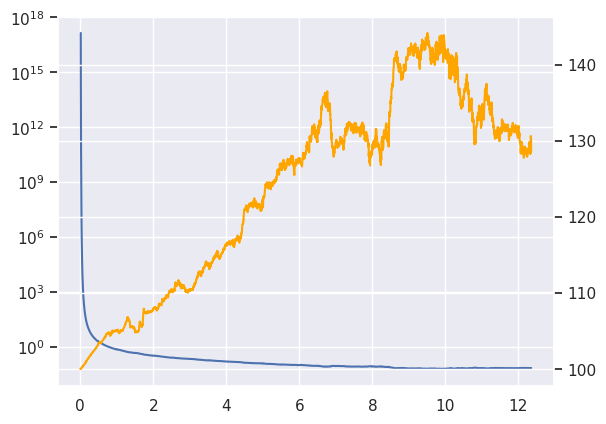

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
x = yc.loc[:,"TTM"].values
y = yc.loc[:,"YTM"].values
p = yc.loc[:,"P"].values
plt.plot(x,y)
plt.yscale("log")
plt.twinx()
plt.plot(x,p,color="orange")
plt.show()

In [30]:
df = pd.DataFrame()
df["bond0"] = yc["YTM"]
df["bond1"] = yc1["YTM"]

/home/marcus/miniconda3/envs/fm/lib/python3.12/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/home/marcus/miniconda3/envs/fm/lib/python3.12/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/home/marcus/miniconda3/envs/fm/lib/python3.12/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/home/marcus/miniconda3/envs/fm/lib/python3.12/site-packages/matplotlib/axis.py:1495: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeInde

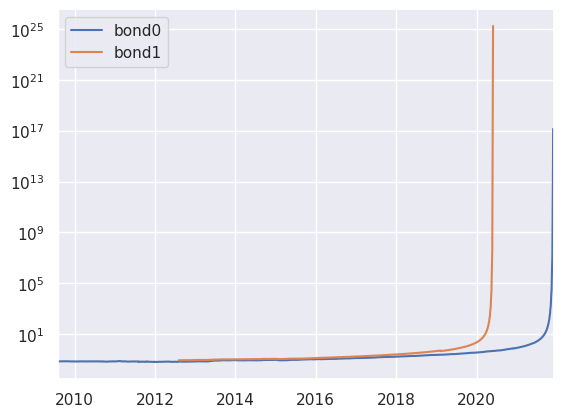

In [33]:
df.plot.line()
plt.yscale("log")

# Yield Curves for every date

In [1]:
import pickle
import pandas as pd
import itertools as it
from datasets import df_info

ilbs = df_info[df_info["TYPE"] == "ILB"].index.values
noms = df_info[df_info["TYPE"]=="NOM"].index.values

with open("export/ytm_ilb_as_nominal_dataframes.pickle","rb") as f:
    data = pickle.load(f)

bonds = data.keys()
dims = ["TTM","YTM"]
tuples = it.product(bonds,dims)
cols = pd.MultiIndex.from_tuples(tuples)

df = pd.DataFrame(columns=cols)

for b,bdf in data.items():
    df[b,"TTM"] = bdf["TTM"]
    df[b,"YTM"] = bdf["YTM"]
    
df

846111              610286               248402            \
                  TTM       YTM       TTM       YTM        TTM       YTM   
1996-07-02  30.435616  0.047933       NaN       NaN        NaN       NaN   
1996-07-03  30.432877  0.047933       NaN       NaN        NaN       NaN   
1996-07-04  30.430137  0.047933       NaN       NaN        NaN       NaN   
1996-07-05  30.427397  0.048527       NaN       NaN        NaN       NaN   
1996-07-08  30.419178  0.048370       NaN       NaN        NaN       NaN   
...               ...       ...       ...       ...        ...       ...   
2023-09-13   3.219178  0.021427  8.221918  0.020055  13.227397  0.020552   
2023-09-14   3.216438  0.021347  8.219178  0.019804  13.224658  0.020454   
2023-09-15   3.213699  0.021885  8.216438  0.020358  13.221918  0.020796   
2023-09-18   3.205479  0.022192  8.208219  0.020469  13.213699  0.020786   
2023-09-19   3.202740  0.022563  8.205479  0.021365  13.210959  0.021095   

               97059Q               5653HV            ... 6561K8     8118P5  \
                  TTM       YTM        TTM       YTM  ...    TTM YTM    TTM   
1996-07-02        NaN       NaN        NaN       NaN  ...    NaN NaN    NaN   
1996-07-03        NaN       NaN        NaN       NaN  ...    NaN NaN    NaN   
1996-07-04        NaN       NaN        NaN       NaN  ...    NaN NaN    NaN   
1996-07-05        NaN       NaN        NaN       NaN  ...    NaN NaN    NaN   
1996-07-08        NaN       NaN        NaN       NaN  ...    NaN NaN    NaN   
...               ...       ...        ...       ...  ...    ...  ..    ...   
2023-09-13  18.230137  0.020753  21.232877  0.020348  ...    NaN NaN    NaN   
2023-09-14  18.227397  0.020651  21.230137  0.020246  ...    NaN NaN    NaN   
2023-09-15  18.224658  0.020994  21.227397  0.020588  ...    NaN NaN    NaN   
2023-09-18  18.216438  0.020986  21.219178  0.020582  ...    NaN NaN    NaN   
2023-09-19  18.213699  0.021297  21.216438  0.020892  ...    NaN NaN    NaN   

               853J3Z     2360RY     615GG0      
           YTM    TTM YTM    TTM YTM    TTM YTM  
1996-07-02 NaN    NaN NaN    NaN NaN    NaN NaN  
1996-07-03 NaN    NaN NaN    NaN NaN    NaN NaN  
1996-07-04 NaN    NaN NaN    NaN NaN    NaN NaN  
1996-07-05 NaN    NaN NaN    NaN NaN    NaN NaN  
1996-07-08 NaN    NaN NaN    NaN NaN    NaN NaN  
...         ..    ...  ..    ...  ..    ...  ..  
2023-09-13 NaN    NaN NaN    NaN NaN    NaN NaN  
2023-09-14 NaN    NaN NaN    NaN NaN    NaN NaN  
2023-09-15 NaN    NaN NaN    NaN NaN    NaN NaN  
2023-09-18 NaN    NaN NaN    NaN NaN    NaN NaN  
2023-09-19 NaN    NaN NaN    NaN NaN    NaN NaN  

[7101 rows x 72 columns]

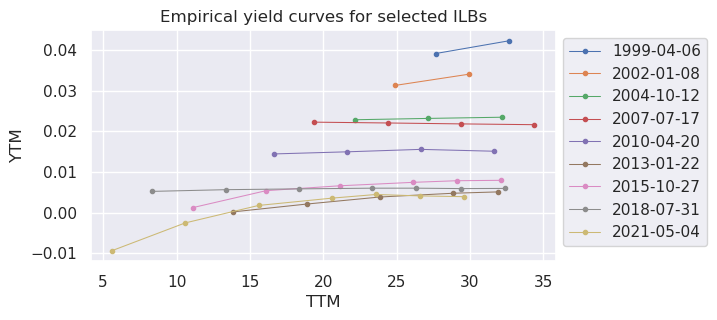

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

pairs = [("846111", "846564"),("610286", "610451"),("248402", "46269V"),("97059Q", "2180M7"),("5653HV", "2180M7"),
         ("5653HV", "6487P3"),("787NK8", "794D5D"),("849UMH", "860K02"),("645HW9", "650WAD")]

ilbs = [pair[0] for pair in pairs]
noms = [pair[1] for pair in pairs]

idx = pd.IndexSlice

def yield_curve(date:str,bonds:list)->pd.Series:
    ttms = df.loc[date,idx[bonds,"TTM"]]
    ytms = df.loc[date,idx[bonds,"YTM"]]
    series = pd.Series(data=ytms.values,index=ttms.values,name=date)
    return series.groupby(series.index).mean()

fig, ax = plt.subplots(figsize=(6,3))
for date in df.index.values[720::720]:
    yc = yield_curve(date,ilbs)
    yc.plot(linestyle="-",marker=".",linewidth=0.75,label=pd.Timestamp(date).strftime("%Y-%m-%d"),ax=ax)

plt.legend()
sns.move_legend(ax, "upper left",bbox_to_anchor=(1,1))
plt.xlabel("TTM")
plt.ylabel("YTM")
plt.title("Empirical yield curves for selected ILBs")
plt.show()

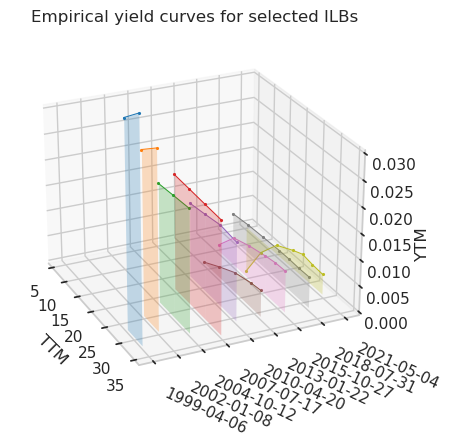

In [199]:
from helper import fill_between_3d

fig = plt.figure()
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(projection="3d")

ax.view_init(elev=25, azim=-25, roll=0)

def color_gen():
    cmap = sns.color_palette("tab10")
    i = 0
    while True:
        yield cmap[i%len(cmap)]
        i +=1
cg = color_gen()

ticks, labels = [], []
for i,date in enumerate(df.index.values[720::90]): #every month
    yc = yield_curve(date,ilbs)
    xs = yc.index.values #ttm
    ys = [i for _ in xs] #ebene//datum
    zs = yc.values #ytm
    if i%8 == 0:
        ticks.append(i)
        labels.append(pd.Timestamp(date).strftime("%Y-%m-%d"))
        c = next(cg)
        ax.plot(xs,ys,zs,linewidth=0.75,markersize=2.5,marker=".",color=c)
        fill_between_3d(ax,xs,ys,zs,xs,ys,np.zeros(len(xs)),alpha=0.25,color=c)

ax.set_yticks(ticks, labels=labels,rotation=-25,ha="left")
ax.set_xlabel("TTM",rotation = -45)
ax.set_zlabel("YTM",rotation=90)
ax.yaxis.set_ticks_position("lower")

ax.set_zlim(0,0.03)

plt.title("Empirical yield curves for selected ILBs")
plt.show()

In [2]:
import pandas as pd

data = pd.read_csv("data/yield_curves.csv",index_col="Date",na_values=" na")
data.index = pd.DatetimeIndex(data.index)
data = data.iloc[:,:-1]
data = data.apply(pd.to_numeric)

In [4]:
import re
import matplotlib.pyplot as plt

def transform(s):
    s = s.strip()[2:-2]
    n = s[:-2]+"."+s[-2:]
    return float(n)

xs = [transform(col) for col in data.columns]
ys = data.loc["2023-08-22"].values

plt.plot(xs,ys)

AttributeError: 'tuple' object has no attribute 'strip'

# Cashflows
Can only compare already matured ILBs - otherwise we can't calculate an index ratio

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import pandas as pd
import seaborn as sns

sns.set_theme()

from bond import Bond, ILB
from datasets import df_info, df_prices


def possible_dates(bond_id):
    return df_prices.loc[:,bond_id].dropna().index

def plot_cashflows(bond_id:str,eval_date:str,cp_only:bool):
    issue_date = df_info.loc[bond_id,"ISSUE DATE"]
    redem_date = df_info.loc[bond_id,"REDEMPTION DATE"]
    coupon = df_info.loc[bond_id,"INDEX LINKED COUP"]
    coupon_freq = Bond.parse_coupon_dates(df_info.loc[bond_id,"COUPON DATES"])
    name = df_info.loc[bond_id,"NAME"]
    
    
    nominal_bond = Bond(issue_date,redem_date,coupon,coupon_freq=coupon_freq,id=bond_id,name=name)
    ilb_bond = ILB(issue_date,redem_date,coupon,coupon_freq=coupon_freq,id=bond_id,name=name)

    nominal_bond.prices = df_prices.loc[:,bond_id]
    ilb_bond.prices = df_prices.loc[:,bond_id]
    
    #eval_date = pd.Timestamp(eval_date)
    eval_price = nominal_bond.prices.loc[eval_date]

    nominal_bond.cashflows(eval_date,eval_price,dirty=False)
    ilb_bond.cashflows(eval_date,eval_price,dirty=False)
    
    nom_acc = Bond(issue_date,redem_date,coupon,coupon_freq=coupon_freq,id=bond_id,name=name)
    nom_acc.cashflows(eval_date,eval_price,dirty=True)

    real_acc = ILB(issue_date,redem_date,coupon,coupon_freq=coupon_freq,id=bond_id,name=name)
    real_acc.cashflows(eval_date,eval_price,dirty=True)

    df_nom = nominal_bond._df_cfs
    df_nom.loc[eval_date,"Accrued Interest"] = -nom_acc.accrued_interest

    df_real = ilb_bond._df_cfs
    df_real.loc[eval_date,"Accrued Interest"] = -real_acc.accrued_interest
    
    #print(df_nom)
    #print(df_real)

    fig, ax = plt.subplots()

    if cp_only:
        df_real[["Coupon"]].plot.bar(stacked=True,ax=ax,position=-0.5,width=0.25,color=sns.color_palette(palette="pastel")[1])
        df_nom[["Coupon"]].plot.bar(stacked=True,ax=ax,position=0.5,width=0.25,color=sns.color_palette(palette="dark")[1])
    else:
        df_real.plot(kind="bar",stacked=True,ax=ax,position=-0.5,width=0.25,color=sns.color_palette(palette="pastel"))
        df_nom.plot(kind="bar",stacked=True,ax=ax,position=0.5,width=0.25,color=sns.color_palette(palette="dark"))  


    plt.legend([mpatches.Patch(color="dimgrey"),mpatches.Patch(color="silver")],["Nominal","Real"])
    plt.show()

In [2]:
ilbs = df_info[(df_info["TYPE"]=="ILB")&(df_info["REDEMPTION DATE"]<pd.Timestamp("2023-12-31"))].index
ilb_dropdown = widgets.Dropdown(options=[(lbl,val) for lbl,val in zip(df_info.loc[ilbs,"NAME"].values,ilbs)],description="ILB")
possible_dates_slider = widgets.SelectionSlider(options=possible_dates(ilb_dropdown.value),description="Evaluation Date",continuous_updates=False)
possible_dates_slider.value = random.choice(possible_dates(ilb_dropdown.value))
cp_only_check = widgets.Checkbox(value=False,description="Coupons only")


def handle_change(change):
    possible_dates_slider.options = possible_dates(change["new"])
    possible_dates_slider.value = random.choice(possible_dates(change["new"]))
    print(change["new"])
    
ilb_dropdown.observe(handle_change,names="value")

widgets.interact(plot_cashflows,bond_id=ilb_dropdown,cp_only=cp_only_check,eval_date=possible_dates_slider)

#display(ilb_dropdown,possible_dates_slider,dirty_check,out)

interactive(children=(Dropdown(description='ILB', options=(('CANADA 1991 4 1/4% 01/12/21 INDXLK.', '597973'), …

<function __main__.plot_cashflows(bond_id: str, eval_date: str, cp_only: bool)>

In [3]:
df_prices.loc[:,ilb_dropdown.value].dropna()

2009-07-30    128.730
2009-07-31    130.290
2009-08-03    130.630
2009-08-04    129.220
2009-08-05    128.500
               ...   
2021-11-25    100.029
2021-11-26    100.012
2021-11-29    100.012
2021-11-30    100.012
2021-12-01    100.012
Name: 597973, Length: 3220, dtype: float64

In [1]:
import seaborn as sns

In [9]:
display(sns.palettes.color_palette("dark"))
display(sns.palettes.color_palette("pastel"))

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

# Aggregation

In [7]:
import pandas as pd
import string
import random
import numpy as np

n=10
data = [[name, val] for name,val in zip(random.choices(string.ascii_uppercase,k=n),np.random.randint(1,high=30,size=n))]

In [32]:
df = pd.DataFrame(data,columns=["name","duration"])
df.index.name = "id"
df["value"] = np.random.random(size=n)
df

,name,duration,value
id,,,
0,E,15,0.459622
1,A,29,0.483179
2,C,19,0.224332
3,R,3,0.761833
4,W,12,0.768689
5,B,5,0.690771
6,A,16,0.731145
7,L,18,0.824094
8,O,18,0.027110


In [38]:

classes = {"0-3y":(0,3),"3-5y":(3,5),"5-10y":(5,10),"10-20y":(10,20),"20y+":(20,np.inf)}
def get_class(x):
    """
    lower boundary exclusive, upper boundary inclusive
    """
    for key, interval in classes.items():
        if interval[0] < x <= interval[1]:
            return key

In [39]:
df["class"] = df["duration"].map(get_class)

In [2]:
from datasets import df_info
df_info

,ISIN CODE,NAME,COUPON,AMOUNT ISSUED,COUPON DATES,INDEX LINKED COUP,COUPONS PER YEAR,1ST COUPON VALUE,OTHER YIELD,RED. YIELD,CURRENCY,ISSUE DATE,MATURITY YEAR,START YEAR,ACTIVE,REDEMPTION DATE,REF CPI BASE,TYPE,DURATION,CLASS
Type,,,,,,,,,,,,,,,,,,,,
597973,CA135087UL60,CANADA 1991 4 1/4% 01/12/21 INDXLK.,7.3104,5175000.0,"01/06,01/12",4.25,2,2.02600,-3.635,NaN,C$,1991-12-10 00:00:00,2021,1991,Dead,2021-12-01 00:00:00,83.07713,ILB,29.975359,20y+
5771H1,CA13501ZCM91,CANADA 1993 PKG. STRIP 01/12/21 INDXLK.,0.0000,NaN,NaN,0.00,0,0.00000,NaN,NaN,C$,1993-06-01 00:00:00,2021,1993,Dead,2021-12-01 00:00:00,NaN,ILB,28.501027,20y+
491970,CA13506ZCL63,CANADA 1993 CPN. STRIP 01/12/21 INDXLK.,0.0000,NaN,NaN,0.00,0,0.00000,NaN,NaN,C$,1993-09-02 00:00:00,2021,1993,Dead,2021-12-01 00:00:00,NaN,ILB,28.246407,20y+
49197U,CA13506ZCG78,CANADA 1993 CPN. STRIP 01/12/19 INDXLK.,0.0000,NaN,NaN,0.00,0,0.00000,NaN,NaN,C$,1993-09-02 00:00:00,2019,1993,Dead,2019-12-01 00:00:00,NaN,ILB,26.246407,20y+
49197V,CA13506ZCH51,CANADA 1993 CPN. STRIP 01/06/20 INDXLK.,0.0000,NaN,NaN,0.00,0,0.00000,NaN,NaN,C$,1993-09-02 00:00:00,2020,1993,Dead,2020-06-01 00:00:00,NaN,ILB,26.748118,20y+
846111,CA135087VS05,CANADA 1995 4 1/4% 01/12/26 INDXLK.,7.6333,5250000.0,"01/06,01/12",4.25,2,2.06100,2.241,NaN,C$,1995-12-07 00:00:00,2026,1995,Active,2026-12-01 00:00:00,87.82571,ILB,30.983573,20y+
846564,CA135087VW17,CANADA 1996 8% 01/06/27 VW17,8.0000,9600000.0,"01/06,01/12",NaN,2,0.67940,NaN,4.0334,C$,1996-05-01 00:00:00,2027-06-10 00:00:00,1996-05-01 00:00:00,NaN,2027-06-10 00:00:00,NaN,NOM,31.106776,20y+
610451,CA135087WL43,CANADA 1998 5 3/4% 01/06/29 S,5.7500,13900000.0,"01/06,01/12",NaN,2,1.87470,NaN,3.8772,C$,1998-02-02 00:00:00,2029-06-10 00:00:00,1998-02-02 00:00:00,NaN,2029-06-10 00:00:00,NaN,NOM,31.350445,20y+
610286,CA135087WV25,CANADA 1999 4% 01/12/31 INDXLK.,6.9046,5800000.0,"01/06,01/12",4.00,2,0.93150,2.129,NaN,C$,1999-03-08 00:00:00,2031,1999,Active,2031-12-01 00:00:00,91.38249,ILB,32.733744,20y+


In [41]:
df[["value","class"]].groupby(by="class",).mean()

,value
class,
1-3y,0.761833
10-20y,0.505832
20y+,0.483179
3-5y,0.700117


# Expected Inflation

In [88]:
import pandas as pd
df = pd.read_csv("data/inflation_expectations_and_bei.csv")
inflation_expectations = df.drop(columns=["INDINF_INFEXP_BOND_G"])
inflation_expectations.dropna(inplace=True)
inflation_expectations.index = pd.DatetimeIndex(data=inflation_expectations["date"])
inflation_expectations.drop(columns=["date"],inplace=True)
inflation_expectations.columns=["2-3y ahead","6-10y ahead"]
inflation_expectations = inflation_expectations/100
inflation_expectations = inflation_expectations.resample("MS").ffill() #upsample from quaterly to monthly data
inflation_expectations

yield_spread = df.loc[:,["date","INDINF_INFEXP_BOND_G"]]
yield_spread.dropna(inplace=True)
yield_spread.index = pd.DatetimeIndex(yield_spread["date"])
yield_spread.drop(columns=["date"],inplace=True)
yield_spread = yield_spread/100
yield_spread.columns = ["yield spread"]
yield_spread

,yield spread
date,
1993-01-01,0.039
1993-02-01,0.036
1993-03-01,0.037
1993-04-01,0.037
1993-05-01,0.038
...,...
2023-05-01,0.018
2023-06-01,0.017
2023-07-01,0.017


In [91]:
from datasets import inflation_expectations

<Axes: xlabel='date'>

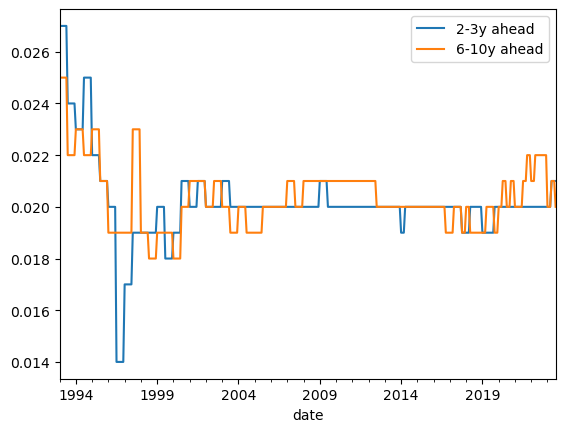

In [93]:
inflation_expectations.plot()

In [1]:
import pandas as pd
from bond import Bond

issue_date= pd.Timestamp("1995-01-03")
redem_date = pd.Timestamp("2023-06-01")
coupon = 4

bond = Bond(issue_date,redem_date,coupon,coupon_freq=["AS-JUN","AS-DEC"],id = 1, name="My Bond")
print(bond)

1 | My Bond | 4
03/01/95 - 01/06/23


In [2]:
eval_date = pd.Timestamp("2020-05-01")
print(bond.cashflows(eval_date,100))

2020-05-01   -101.665753
2020-06-01      2.000000
2020-12-01      2.000000
2021-06-01      2.000000
2021-12-01      2.000000
2022-06-01      2.000000
2022-12-01      2.000000
2023-06-01    102.000000
dtype: float64


In [9]:
print(bond.ytm(eval_date,100))

0.04036955901174215


In [4]:
bond._df_cfs

,Initial,Coupon,Redemption
2020-05-01,-101.665753,NaN,NaN
2020-06-01,NaN,2.0,NaN
2020-12-01,NaN,2.0,NaN
2021-06-01,NaN,2.0,NaN
2021-12-01,NaN,2.0,NaN
2022-06-01,NaN,2.0,NaN
2022-12-01,NaN,2.0,NaN
2023-06-01,NaN,2.0,100.0


In [1]:
import pandas as pd
from cpi import RefCPI

cpi = RefCPI()
eval_date = pd.Timestamp("1995-01-03")

print(cpi.ref_cpi(eval_date))

85.73226


<Axes: xlabel='REF_DATE'>

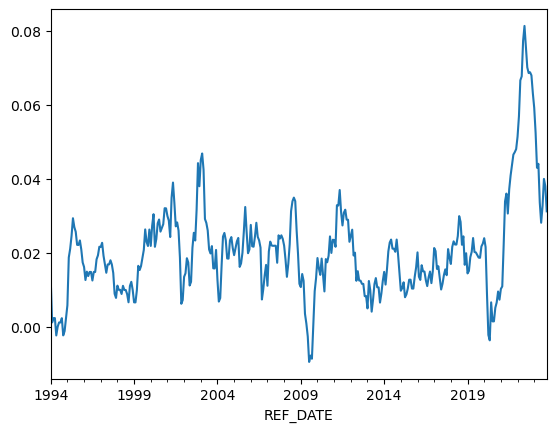

In [13]:
cpi_pa = cpi.series.loc["1993-01-01":].pct_change(periods=12).dropna()
cpi_pa.plot()

In [1]:
import pandas as pd
from bond import ILB

issue_date= pd.Timestamp("1995-01-03")
redem_date = pd.Timestamp("2023-06-01")
coupon = 4

ilb = ILB(issue_date,redem_date,coupon,coupon_freq=["AS-JUN","AS-DEC"],id = "002", name="My ILB", cpi_base = 85.73226)
print(ilb)

002 | My ILB | 4
03/01/95 - 01/06/23


In [2]:
ilb.index_ratios

1995-01-03    1.000000
1995-06-01    1.017120
1995-12-01    1.024120
1996-06-01    1.032280
1996-12-01    1.039280
1997-06-01    1.052110
1997-12-01    1.056780
1998-06-01    1.062610
1998-12-01    1.063780
1999-06-01    1.073110
1999-12-01    1.091770
2000-06-01    1.105770
2000-12-01    1.120930
2001-06-01    1.132600
2001-12-01    1.150090
2002-06-01    1.153590
2002-12-01    1.176920
2003-06-01    1.202580
2003-12-01    1.202580
2004-06-01    1.211910
2004-12-01    1.224740
2005-06-01    1.239910
2005-12-01    1.264400
2006-06-01    1.266730
2006-12-01    1.273730
2007-06-01    1.295890
2007-12-01    1.305230
2008-06-01    1.313390
2008-12-01    1.349550
2009-06-01    1.329720
2009-12-01    1.337890
2010-06-01    1.348380
2010-12-01    1.363550
2011-06-01    1.392710
2011-12-01    1.406710
2012-06-01    1.419540
2012-12-01    1.423030
2013-06-01    1.433530
2013-12-01    1.438200
2014-06-01    1.455690
2014-12-01    1.467360
2015-06-01    1.473190
2015-12-01    1.482520
2016-06-01 

In [6]:
eval_date = pd.Timestamp("2020-01-03")
ilb.cashflows(eval_date,100,dirty=True)

2020-01-03   -160.235934
2020-06-01      3.186660
2020-12-01      3.193660
2021-06-01      3.256660
2021-12-01      3.333640
2022-06-01      3.473600
2022-12-01      3.562260
2023-06-01    184.767900
dtype: float64

In [9]:
ilb._df_cfs

,Initial,Coupon,Redemption
2020-05-01,-160.266,NaN,NaN
2020-06-01,NaN,3.18666,NaN
2020-12-01,NaN,3.19366,NaN
2021-06-01,NaN,3.25666,NaN
2021-12-01,NaN,3.33364,NaN
2022-06-01,NaN,3.47360,NaN
2022-12-01,NaN,3.56226,NaN
2023-06-01,NaN,3.62290,181.145


In [13]:
ilb.accrued_interest

2.6696429156066253